In [1]:
import numpy as np
import torch
from PIL import Image
import requests
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/src")
    
from data.lagrangian_datatools import *
from torchvision.transforms import Compose, Lambda, ToPILImage, CenterCrop, Resize, ToTensor as ToVisionTensor
import matplotlib.pyplot as plt
import importlib
from diffusion import *
from invariant_model import ScIDiff
import utils as utils
from torch import nn
import yaml
from attrdict import AttrDict

In [2]:
importlib.reload(sys.modules['diffusion'])
importlib.reload(sys.modules['invariant_model'])
importlib.reload(sys.modules['utils'])
importlib.reload(sys.modules['data.lagrangian_datatools'])

<module 'data.lagrangian_datatools' from '/home/maria/Documents/github/multiscale-turbulence/src/data/lagrangian_datatools.py'>

In [3]:
# Define beta schedule
T = 800
betas = tanh61_beta_schedule(timesteps=T)

# initialize diffusion
diffuser = GaussianDiffusion(betas=betas)

In [7]:

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)


image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToVisionTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),
    
])

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

x_start = transform(image).unsqueeze(0)
x_start.shape

torch.Size([1, 3, 128, 128])

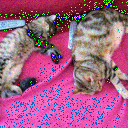

In [9]:
# take time step
t = torch.tensor([400])

# add noise
x_noisy, added_noise = diffuser.forward_diffusion_process(x_start, t=t)

#transform noisy vector back to RGB image
noisy_image = reverse_transform(x_noisy.squeeze())
noisy_image

## Adding noise

In [10]:
# Loading the data
filename = "../data/velocities.npy"
d1 = ParticleDataset(npy_filename=filename, root_dir=".", transform=ToTensor()) # shape is [N,T,3]

In [11]:
x_start = d1[0]
x_start.shape
# watch out, this is a 2D tensor, not 3D as it is usually required for interpolation,etc.
# it is also not channel first, but channel last

torch.Size([2000, 3])

Text(0.5, 0, 't')

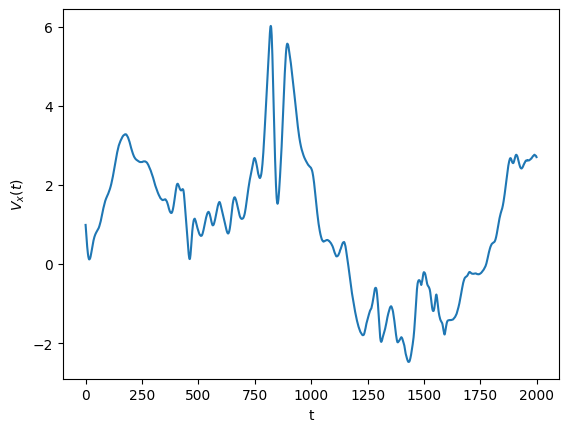

In [12]:
plt.plot(np.arange(2000), x_start[:,0])
plt.ylabel(r"$V_x(t)$")
plt.xlabel("t")

add the noise to the data


In [15]:
# take any time step
t = torch.tensor([790])

# add noise
x_noisy, added_noise = diffuser.forward_diffusion_process(x_start, t=t)

Text(0.5, 0, 't')

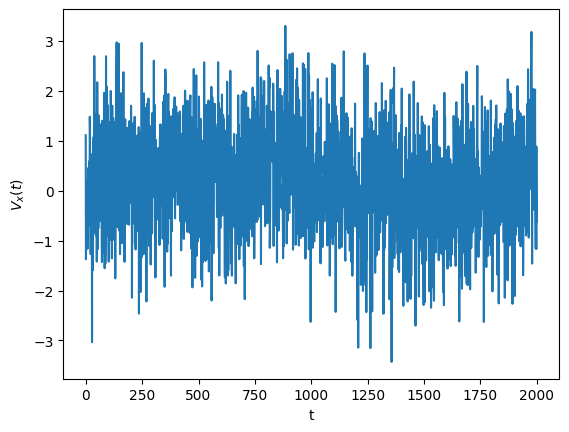

In [16]:
plt.plot(np.arange(2000), x_noisy[:,0])
plt.ylabel(r"$V_x(t)$")
plt.xlabel("t")

ok so the noise addition works for our dataset

## Model - forward pass

now let's try to build the denoising neural network

In [7]:
with open("../src/params.yaml") as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)  # config is dict
    cfg = AttrDict(config)

ScIDiff_params = cfg.parameters
ScIDiff_params.coordinate = None if ScIDiff_params.coordinate==-1 else ScIDiff_params.coordinate
ScIDiff_params.num_coords = 3 if ScIDiff_params.coordinate is None else 1

In [92]:
model = ScIDiff(ScIDiff_params)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  341481


ScIDiff(
  (diffusion_embedding): SinusoidalPositionEmbeddings(
    (projection1): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
    )
    (projection2): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): SiLU()
    )
  )
  (blocks): ModuleList(
    (0): ConvBlock(
      (time_embed_layers): Sequential(
        (0): SiLU()
        (1): Linear(in_features=512, out_features=8, bias=True)
      )
      (in_conv): Sequential(
        (0): Conv1d(3, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): SiLU()
      )
      (out_conv): Sequential(
        (0): Conv1d(8, 3, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): SiLU()
      )
    )
    (1): ConvBlock(
      (time_embed_layers): Sequential(
        (0): SiLU()
        (1): Linear(in_features=512, out_features=8, bias=True)
      )
      (in_conv): Sequential(
        (0): Conv1d(3, 8, kernel_size=(3,), stride=(1,), padding=(1,))
     

In [23]:
model.blocks[0].in_conv[0].weight.dtype

torch.float32

now we have to put the input in the correct shape for the model

In [42]:
# convert to shape (BATCH, CHANNELS, LENGTH)
sample_batch = d1[0:5].permute(0,2,1)
print(sample_batch.shape)

# padd each sample with zeros at the beginning and end until length is 2048
sample_batch = F.pad(sample_batch, (24,24), value=0)
print(sample_batch.shape)
print(sample_batch.dtype)
print(sample_batch[0, 0,:])
print(sample_batch[0, 0,23:28])



torch.Size([5, 3, 2000])
torch.Size([5, 3, 2048])
torch.float32
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0.0000, 0.9902, 0.9069, 0.8229, 0.7403])


In [43]:
# interpolate the sample in 7 levels
batch_interp = utils.interpolate_nscales(sample_batch, scales=7)
print(batch_interp.keys)
for k,v in batch_interp.items():
    print(v.shape)

<built-in method keys of dict object at 0x7f264d916a80>
torch.Size([5, 3, 2048])
torch.Size([5, 3, 1024])
torch.Size([5, 3, 512])
torch.Size([5, 3, 256])
torch.Size([5, 3, 128])
torch.Size([5, 3, 64])
torch.Size([5, 3, 32])


In [44]:
print(sample_batch.dtype)

torch.float32


now we're going to test if the model can perform one forward pass without giving errors

In [49]:
# first assign the diffusion times to the batch
# create a tensor with random diffusion times for each sample in the batch
difussion_times = torch.randint(0, T, (sample_batch.shape[0],))
print(difussion_times)

tensor([732, 414, 302, 752, 200])


In [73]:
 # diffusion process
noisy_batch, noise = diffuser.forward_diffusion_process_dict(batch_interp, difussion_times)

Text(0.5, 0, 't')

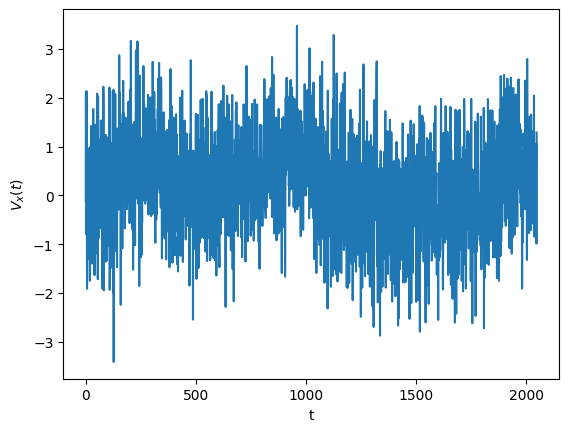

In [74]:
plt.plot(np.arange(2048), noisy_batch[0][0,0,:]) # at the highest resolution, level of index 0 of the pyramid
plt.ylabel(r"$V_x(t)$")
plt.xlabel("t")

Text(0.5, 0, 't')

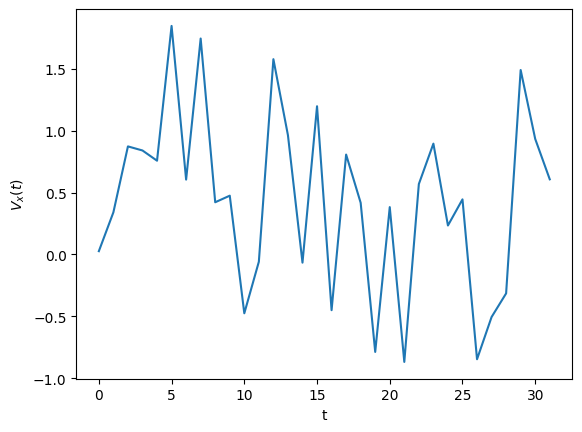

In [75]:
plt.plot(np.arange(2048/2**6), noisy_batch[6][0,0,:]) # at the lowest resolution, level of index 6 of the pyramid
plt.ylabel(r"$V_x(t)$")
plt.xlabel("t")

In [93]:
# forward pass
pred = model(batch_interp, difussion_times)

In [77]:
# loss
loss_fn = nn.MSELoss(reduction="mean")
loss = utils.mse_loss(pred[0], batch_interp[0])
dummy_loss = utils.mse_loss(batch_interp[0], batch_interp[0])

In [76]:
loss_fn(pred[0], batch_interp[0])

tensor(5.4663, grad_fn=<MseLossBackward0>)

In [69]:
print('loss: ', loss)
print('dummy loss: ', dummy_loss)

loss:  tensor(5.5955, grad_fn=<MeanBackward0>)
dummy loss:  tensor(0.)


Text(0.5, 0, 't')

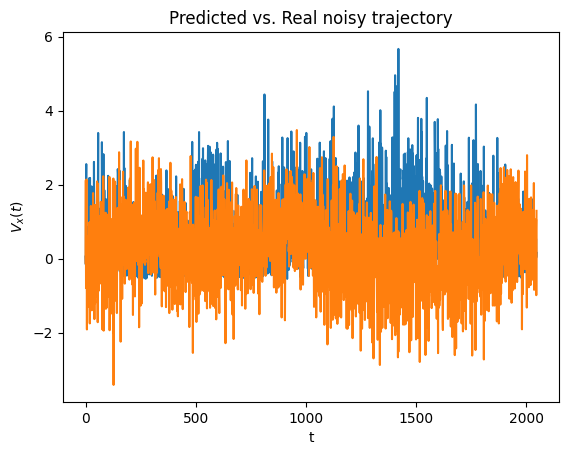

In [79]:
plt.plot(np.arange(2048), pred[0][0,0,:].detach().numpy())
plt.plot(np.arange(2048), batch_interp[0][0,0,:])
plt.title("Predicted vs. Real noisy trajectory")
plt.ylabel(r"$V_x(t)$")
plt.xlabel("t")

Text(0.5, 0, 't')

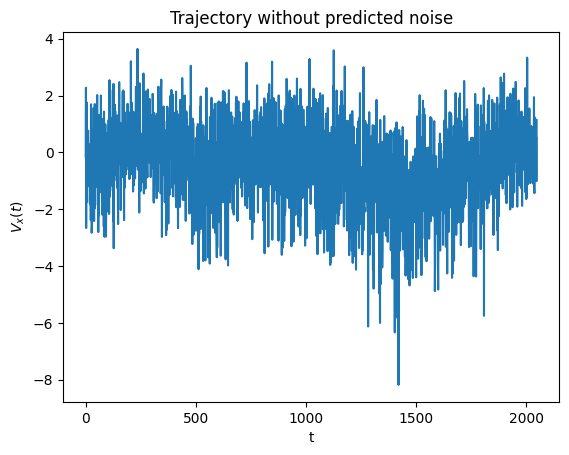

In [80]:
# Here we're just going to do a dummy test of what could the model be actually envisioning
# as a real trajectory, by substracting the predicted noise from the original trajectory.
plt.plot(np.arange(2048), batch_interp[0][0,0,:] - pred[0][0,0,:].detach().numpy())
plt.title("Trajectory without predicted noise")
plt.ylabel(r"$V_x(t)$")
plt.xlabel("t")

### Test the data loader


In [20]:
filename = "../data/subsampled_velocities.npy"
#transforms = [ToTensor(), Lambda(lambda x: x.permute(1, 0)), Lambda(lambda x: x[0, :].unsqueeze(0))]
#dataset = ParticleDataset(filename, transform=Compose(transforms))
dataset = dataset_from_file(filename, batch_size=5, levels=5, coordinate=0, is_distributed=False)

In [21]:
batch = next(iter(dataset))
batch[0].shape

torch.Size([5, 1, 2048])

Text(0.5, 0, 't')

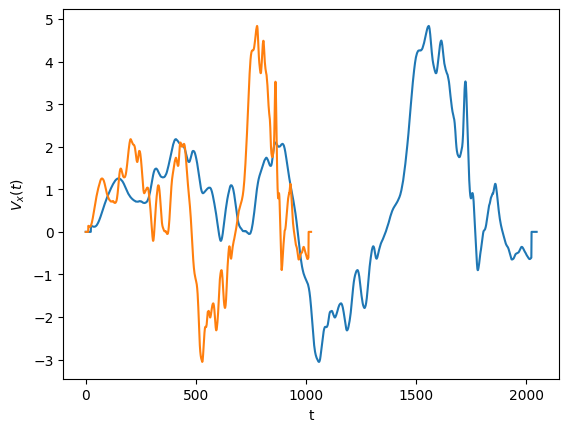

In [22]:
plt.plot(np.arange(2048), batch[0][0,0,:]) # at full resolution
plt.plot(np.arange(1024), batch[1][0,0,:]) # at half resolution, level 1 of the pyramid
plt.ylabel(r"$V_x(t)$")
plt.xlabel("t")

## Inference

In [4]:
talphas = 1 - betas.numpy()
talphas_cum = np.cumprod(talphas)

# this is the same as the training noise for now
inference_noise_schedule = betas.numpy()
alphas = 1 - inference_noise_schedule
alphas_cum = np.cumprod(alphas)

In [8]:
x_0 = torch.randn(ScIDiff_params.batch_size, ScIDiff_params.num_coords, ScIDiff_params.traj_len + 48, device=torch.device("cpu"))
gen_x = utils.interpolate_nscales(x_0, scales=ScIDiff_params.levels)

0 torch.Size([64, 3, 2048])
1 torch.Size([64, 3, 1024])
2 torch.Size([64, 3, 512])
3 torch.Size([64, 3, 256])
4 torch.Size([64, 3, 128])
5 torch.Size([64, 3, 64])
6 torch.Size([64, 3, 32])


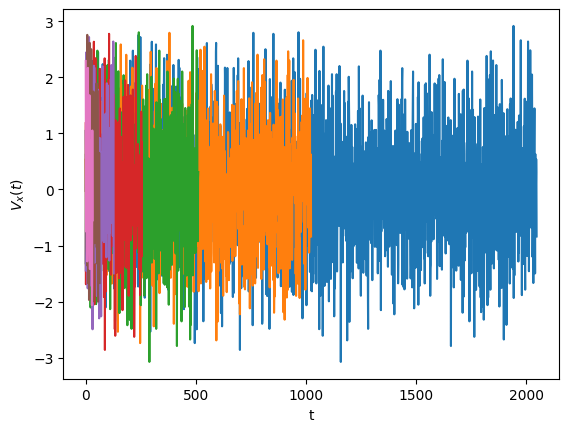

In [9]:
for k, v in gen_x.items():
    print(k, v.shape)
    plt.plot(np.arange(v.shape[-1]), v[0,0,:]) 
    plt.ylabel(r"$V_x(t)$")
    plt.xlabel("t")

In [10]:
# loading model
chck_path = "../experiments/20230720/0000001/weights-350000.pt"
device = torch.device("cpu")
checkpoint = torch.load(chck_path, map_location=device)
model = ScIDiff(ScIDiff_params).to(device=device)
model.load_state_dict(checkpoint["model"]) # if the params settings do not match with the checkpoint, this will fail
model.eval()


ScIDiff(
  (diffusion_embedding): SinusoidalPositionEmbeddings(
    (projection1): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
    )
    (projection2): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): SiLU()
    )
  )
  (blocks): ModuleList(
    (0): ConvBlock(
      (time_embed_layers): Sequential(
        (0): SiLU()
        (1): Linear(in_features=512, out_features=8, bias=True)
      )
      (in_conv): Sequential(
        (0): Conv1d(3, 8, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): SiLU()
      )
      (out_conv): Sequential(
        (0): Conv1d(8, 3, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): SiLU()
      )
    )
    (1): ConvBlock(
      (time_embed_layers): Sequential(
        (0): SiLU()
        (1): Linear(in_features=512, out_features=8, bias=True)
      )
      (in_conv): Sequential(
        (0): Conv1d(3, 8, kernel_size=(3,), stride=(1,), padding=(1,))
     

In [43]:
betas[-5:]

tensor([0.2053, 0.2550, 0.3377, 0.5033, 0.9990])

In [97]:
betas[:5]

tensor([1.2315e-07, 1.2532e-07, 1.2754e-07, 1.2979e-07, 1.3208e-07])

In [44]:
alphas[-5:]

array([0.7947138 , 0.7450379 , 0.6622507 , 0.4966843 , 0.00099999],
      dtype=float32)

In [51]:
alphas[-5:]**0.5

array([0.8914672 , 0.8631558 , 0.8137879 , 0.70475835, 0.03162257],
      dtype=float32)

In [49]:
1/alphas[-5:]**0.5

array([ 1.1217463,  1.1585394,  1.2288214,  1.4189261, 31.62298  ],
      dtype=float32)

There is a huge gap between the last and one before the last alpha values for this noise schedule (tahn61). This makes the values of the velocities explode since the beginning of the sapling process. Hence, we have to perform clamping to [-1,1].

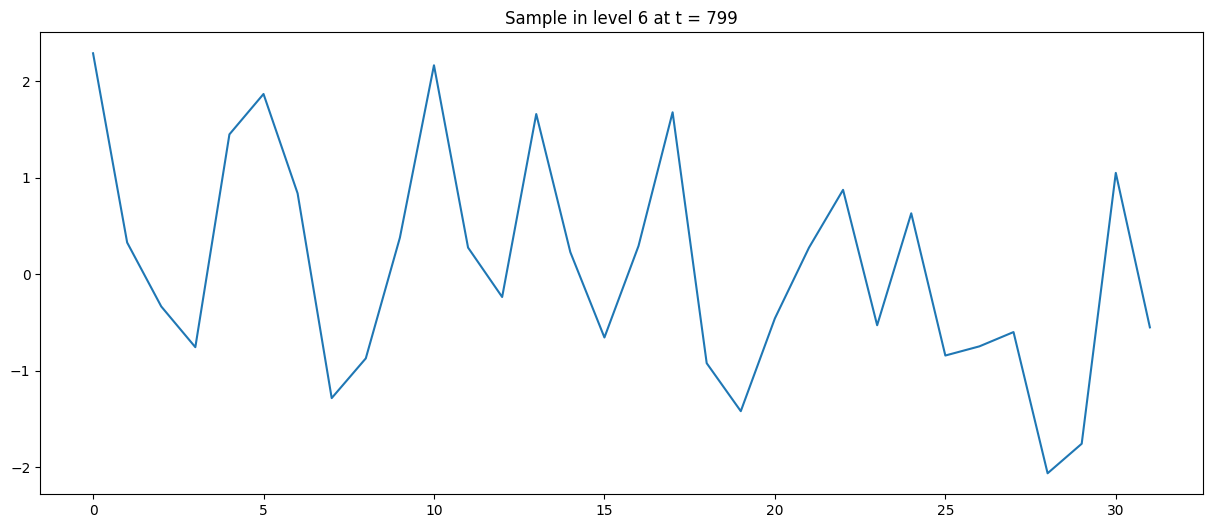

sigma =  0.9984508999723154


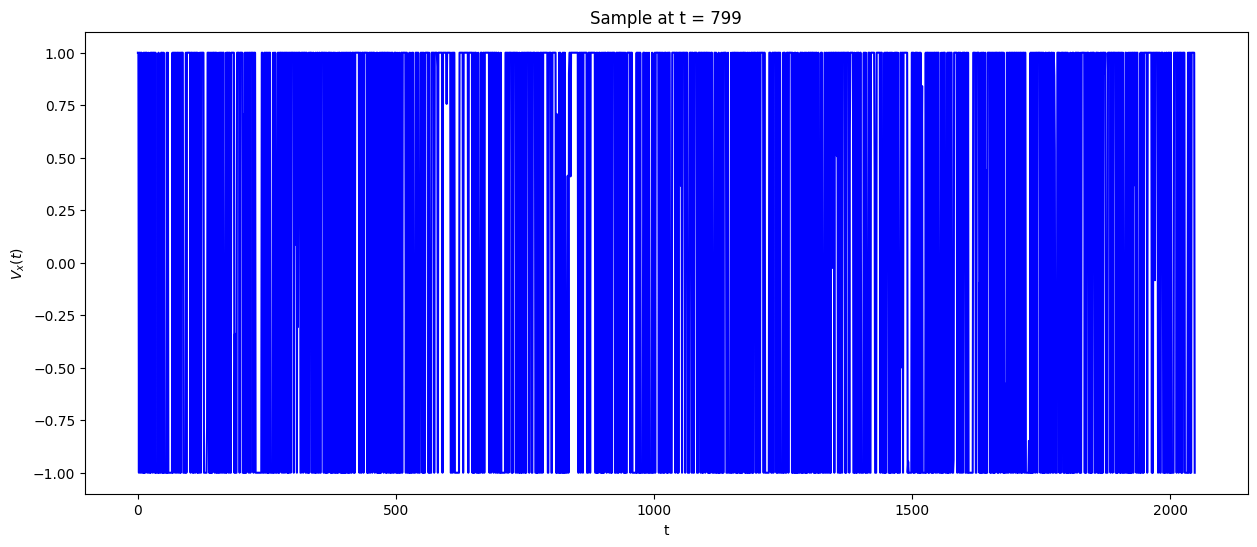

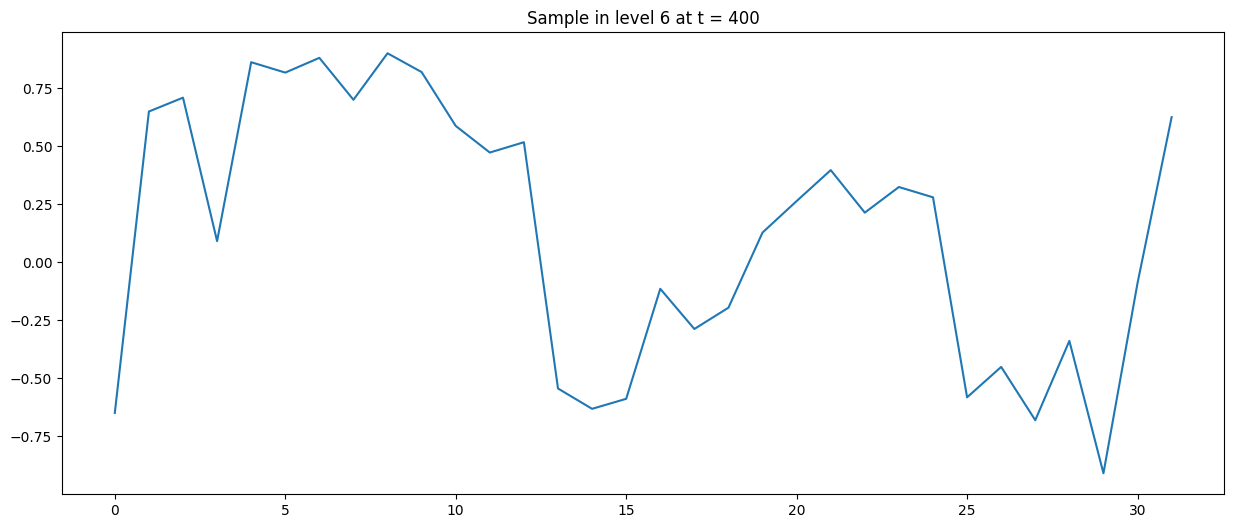

sigma =  0.01148642605901726


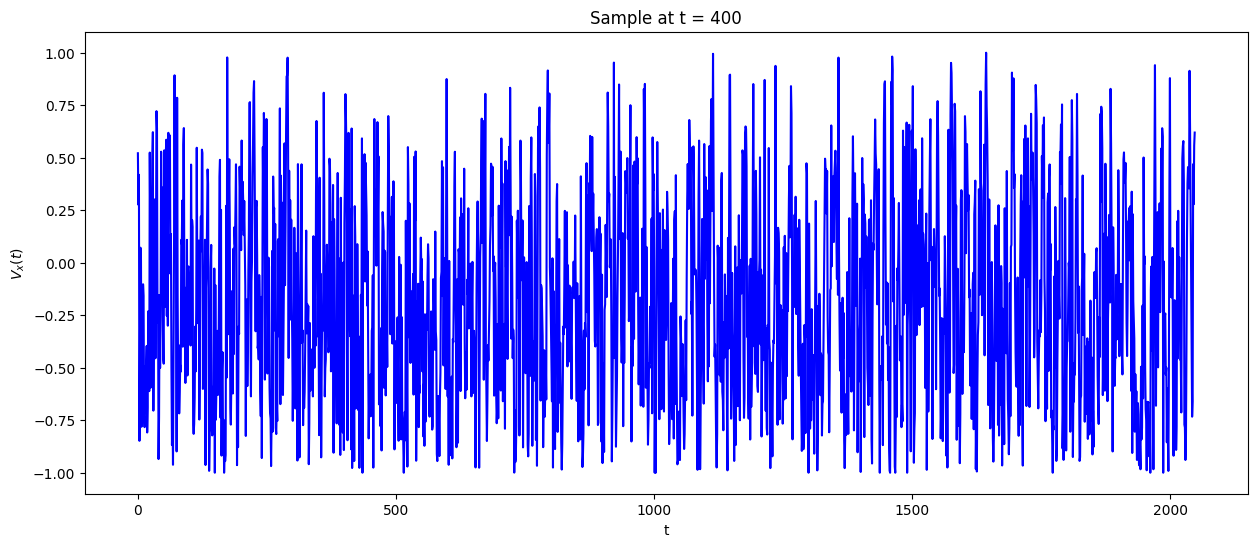

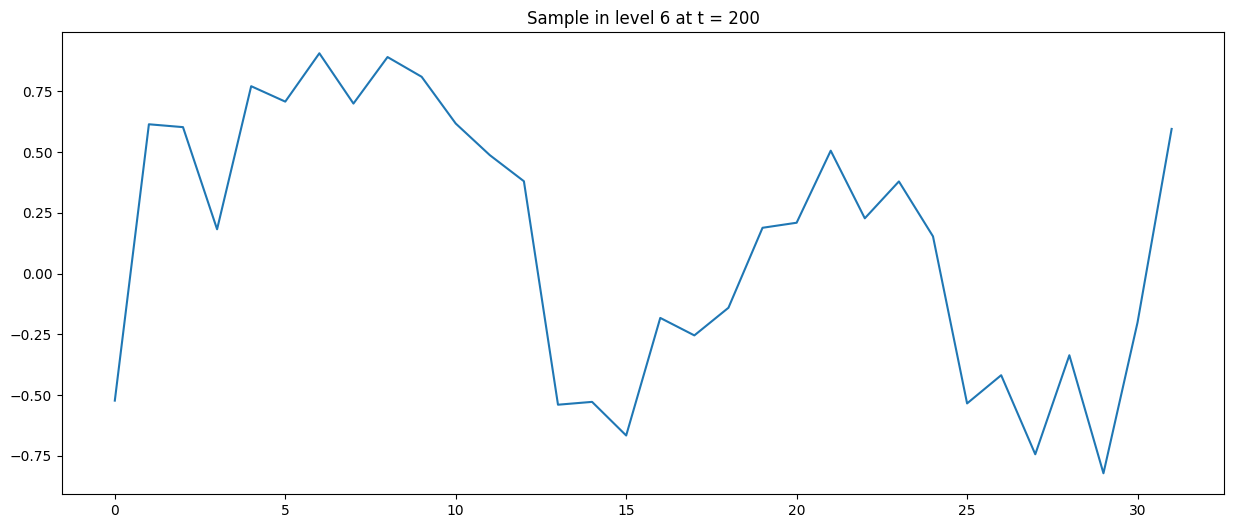

sigma =  0.0020012404551821464


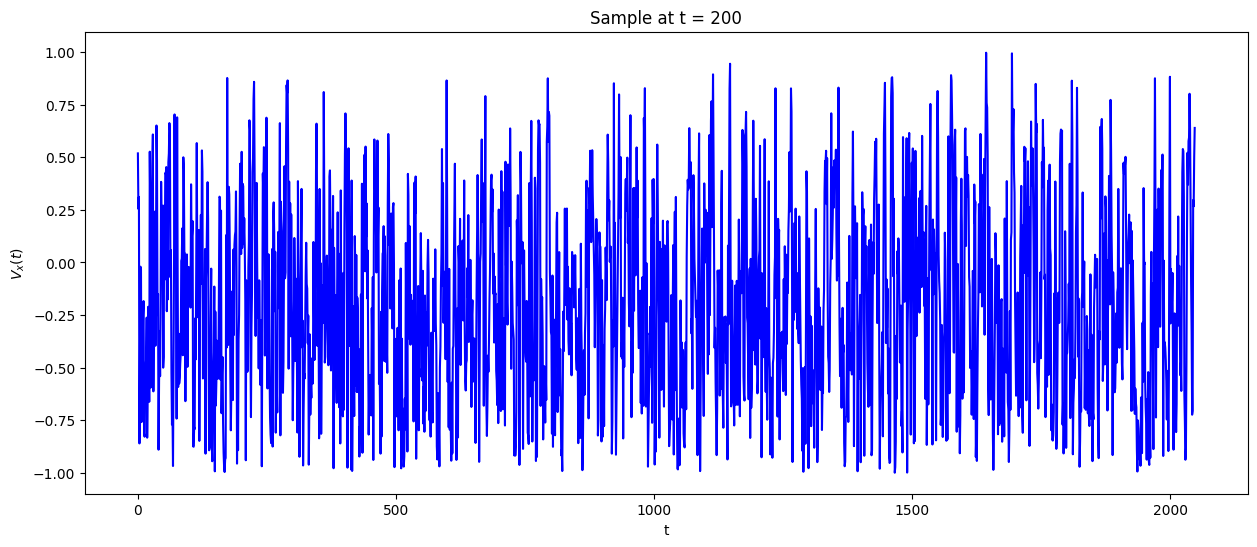

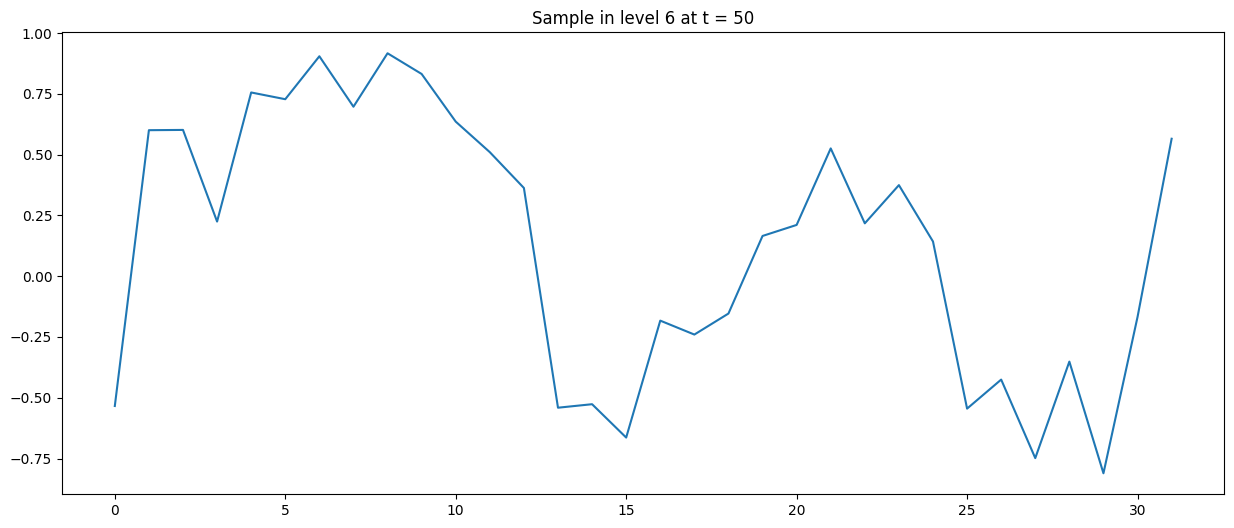

sigma =  0.0005353738838752679


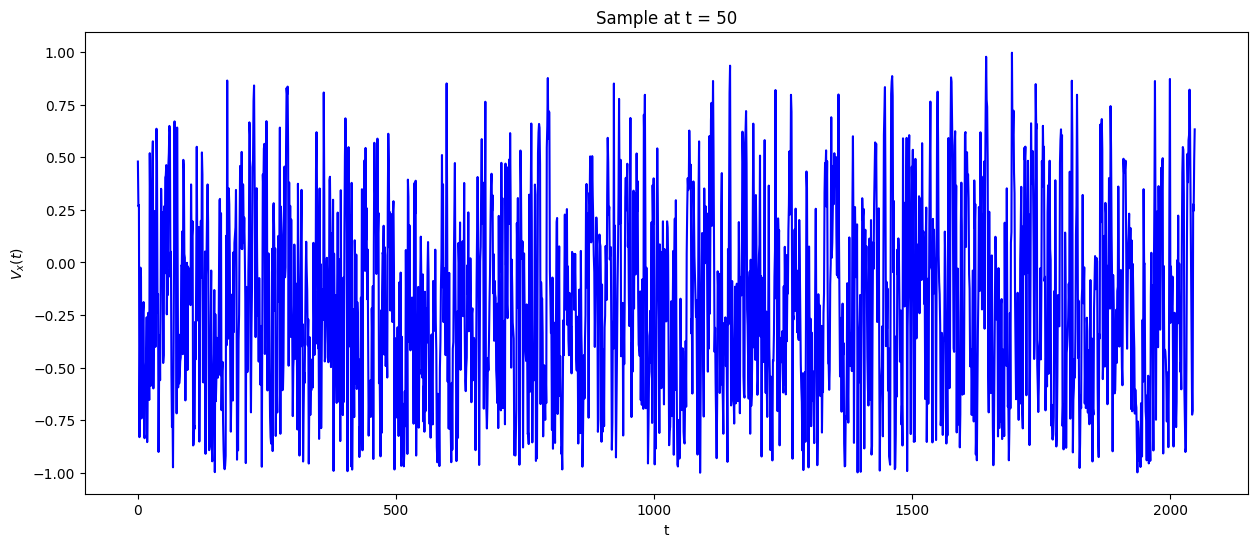

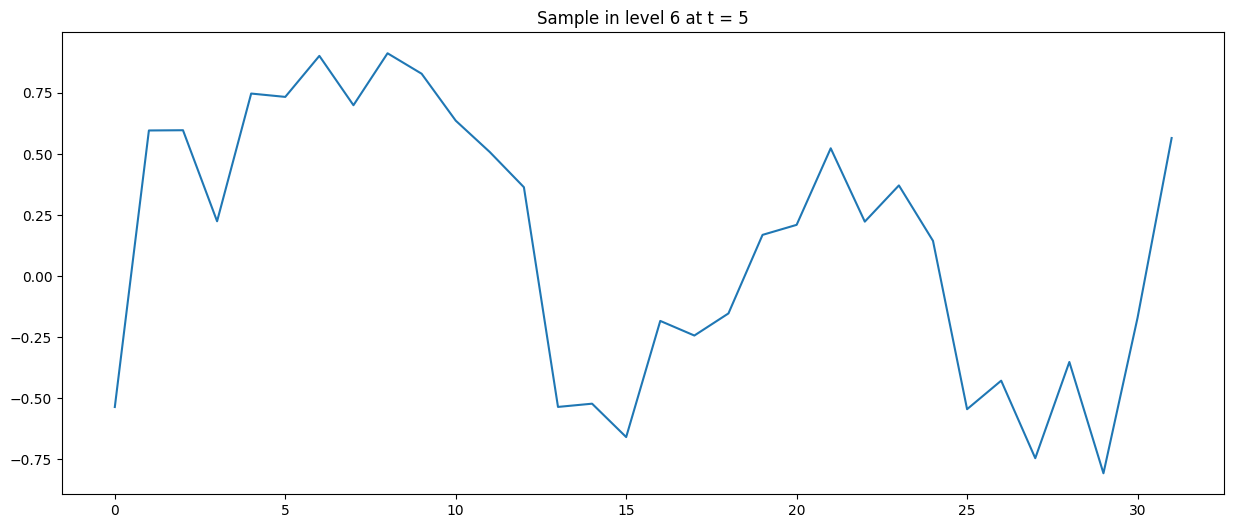

sigma =  0.00033467671005406676


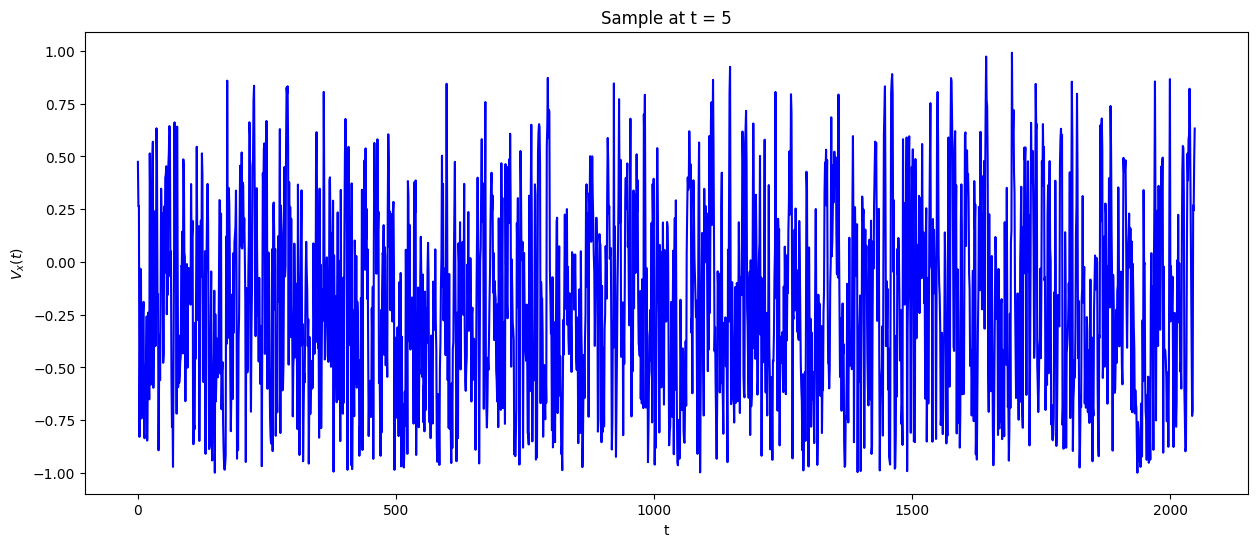

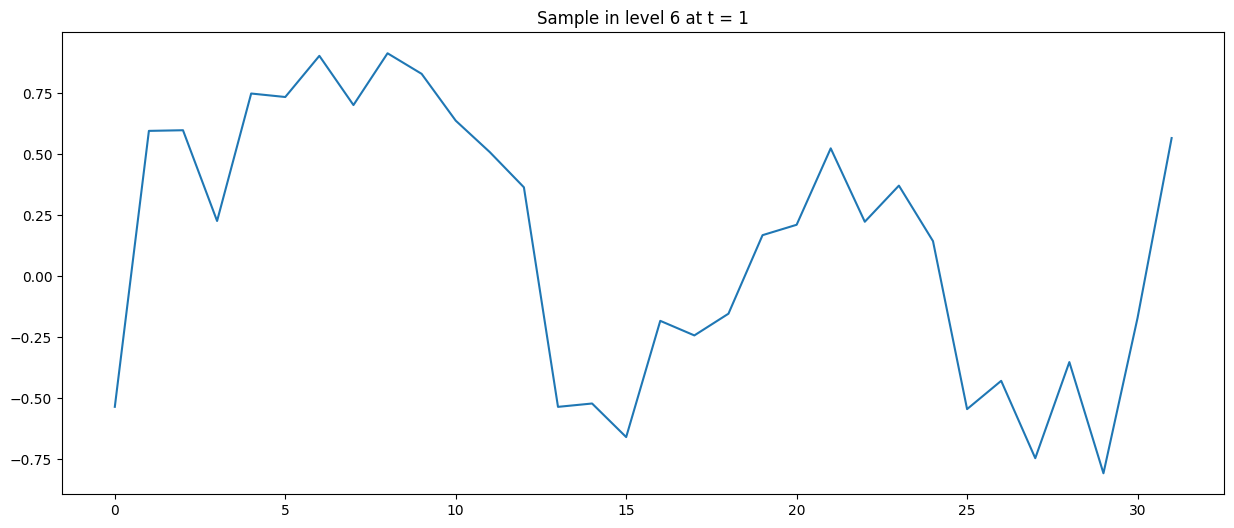

sigma =  0.00025032307366513524


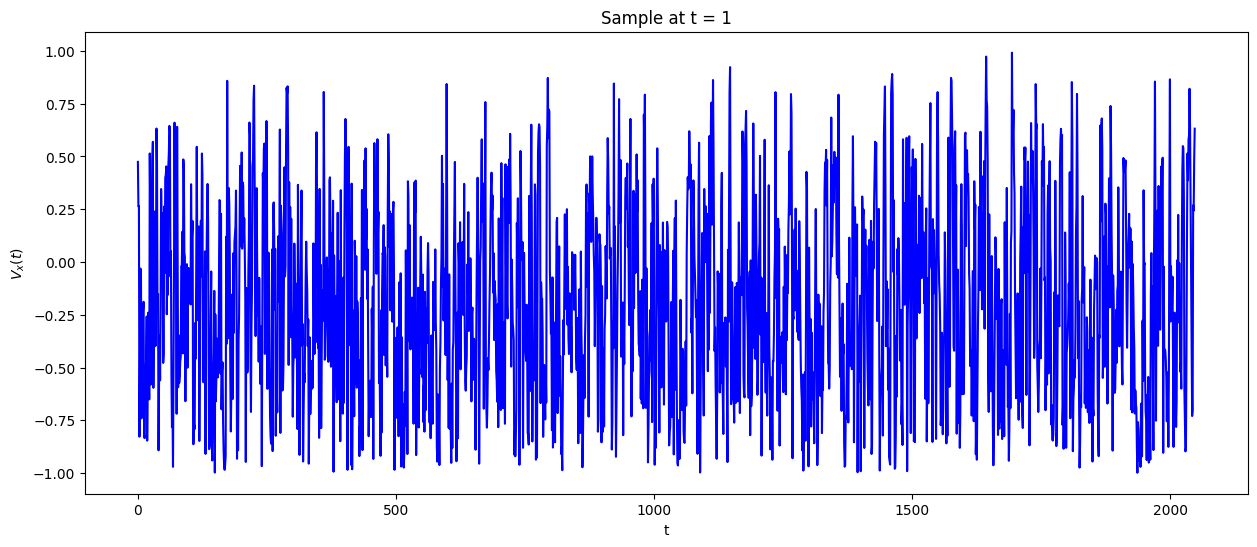

In [11]:
t_plots = [799, 400, 200, 50, 5, 1]
with torch.no_grad():
    # check the last 5 steps
    for t in range(len(alphas)-1, 0, -1):
        c1 = 1 / alphas[t]**0.5
        c2 = inference_noise_schedule[t] / (1 - alphas_cum[t])**0.5
        # plot the first sample at the last level
        if t in t_plots:
            plt.figure(figsize=(15, 6))
            plt.title("Sample in level 6 at t = {}".format(t))
            plt.plot(np.arange(gen_x[6].shape[-1]), gen_x[6][0, 0, :].cpu().numpy())
            plt.show()
        pred_noise = model(gen_x, torch.tensor([t], device=device))
        # denoise at every scale
        for level, v in pred_noise.items():
            gen_x[level] = c1 * (gen_x[level] - c2 * v)
            if(t > 0):
                noise = torch.randn_like(gen_x[level]).to(device)
                sigma = ((1.0 - alphas_cum[t-1]) / (1.0 - alphas_cum[t]) * inference_noise_schedule[t])**0.5
                gen_x[level] += sigma * noise     
                gen_x[level] = gen_x[level].clamp(-1.0, 1.0)
        if t in t_plots:
            print("sigma = ", sigma)
            plt.figure(figsize=(15, 6))
            plt.plot(np.arange(gen_x[0].shape[-1]), gen_x[0][0,0,:], color="blue")
            plt.ylabel(r"$V_x(t)$")
            plt.xlabel("t")
            plt.title("Sample at t = {}".format(t))
            plt.show()

Choosing sigma = inference_noise_schedule[t] ends up in trajectories noisier; looking like codebars